## Isotonic regression

Problem data generation. (This code is in a Jupyter Notebook.)

In [3]:
import cvxpy as cp
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(0)
A = np.random.randn(20,20)
x_true = np.cumsum(np.random.rand(20))
b = A@x_true + 2*np.random.randn(20)


def huber_loss(x) :
    return np.sum((x**2)*(np.abs(x)<=1)+(2*np.sign(x)*x-1)*(np.abs(x)>1))

def huber_grad(x) :
    return 2*x*(np.abs(x)<=1) + 2*np.sign(x)*(np.abs(x)>1)

CVXPY solution

24.733210916870362
[-0.28 -0.28 0.92 2.14 3.39 3.39 3.39 3.73 3.73 3.73 5.29 5.52 5.52 6.08
 6.61 7.35 7.35 7.35 7.79 7.79]


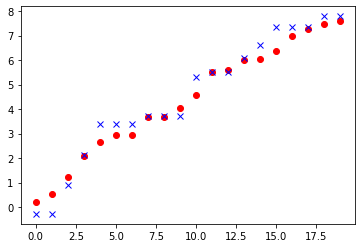

In [4]:
x = cp.Variable(20)

objective = cp.Minimize(sum(cp.huber(A@x-b,1)))

constraints = [x[1:]>=x[:-1]]

p_star = cp.Problem(objective, constraints).solve(solver='ECOS')

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(p_star)
print(x.value)

plt.plot(np.arange(20),x_true, color="red", linestyle="", marker='o')
plt.plot(np.arange(20),x.value, color="blue", linestyle="", marker='x')
plt.show()

DYS iteration

In [5]:
# Computes projection onto the set {x_{i+1}-x_i >= 0, i even}
def even_proj(y):
    proj = y.copy()
    for i in range(len(y)//2):
        if proj[2*i]>proj[2*i+1]:
            proj[2*i] = (proj[2*i]+proj[2*i+1])/2
            proj[2*i+1] = proj[2*i]
    return proj


# Computes projection onto the set {x_{i+1}-x_i >= 0, i odd}
def odd_proj(y):
    proj = y.copy()
    for i in range((len(y)-1)//2):
        if proj[2*i+1]>proj[2*i+2]:
            proj[2*i+1] = (proj[2*i+1]+proj[2*i+2])/2
            proj[2*i+2] = proj[2*i+1]
    return proj



zk = np.zeros(20)
alpha = 0.01

# DYS
for k in range(5000):
    xkhalf = odd_proj(zk)
    xk1 = even_proj(2*xkhalf-zk-alpha*A.T@huber_grad(A@xkhalf-b))
    zk = zk+xk1-xkhalf
    

print('Optimal value from CVXPY:', p_star)
print('Optimal value from DYS:  ', huber_loss(A@xk1-b))

print('\nx^* from CVXPY:  ',x.value)
print('x^k from DYS: ',xk1)

Optimal value from CVXPY: 24.733210916870362
Optimal value from DYS:   24.733210919782255

x^* from CVXPY:   [-0.28 -0.28 0.92 2.14 3.39 3.39 3.39 3.73 3.73 3.73 5.29 5.52 5.52 6.08
 6.61 7.35 7.35 7.35 7.79 7.79]
x^k from DYS:  [-0.28 -0.28 0.92 2.14 3.39 3.39 3.39 3.73 3.73 3.73 5.29 5.52 5.52 6.08
 6.61 7.35 7.35 7.35 7.79 7.79]


PAPC iteration

In [6]:
# Define the matrix D
from scipy.linalg import circulant

D = circulant(np.concatenate(([1,-1],np.zeros(18))))[1:,:]

uk = np.zeros(19)
xk = np.zeros(20)
alpha, beta = 0.01, 10

# PAPC
for k in range(5000):
    uk = np.minimum(uk+beta*D@(xk-alpha*D.T@uk-alpha*A.T@huber_grad(A@xk-b)),0)
    xk = xk - alpha*(np.matmul(D.T,uk) + A.T@huber_grad(A@xk-b))
    
print('Optimal value from CVXPY:', p_star)
print('Optimal value from PAPC: ', huber_loss(A@xk-b))

print('\nx^* from CVXPY:   ',x.value)
print('x^k from PAPC: ',xk)

Optimal value from CVXPY: 24.733210916870362
Optimal value from PAPC:  24.733210919782262

x^* from CVXPY:    [-0.28 -0.28 0.92 2.14 3.39 3.39 3.39 3.73 3.73 3.73 5.29 5.52 5.52 6.08
 6.61 7.35 7.35 7.35 7.79 7.79]
x^k from PAPC:  [-0.28 -0.28 0.92 2.14 3.39 3.39 3.39 3.73 3.73 3.73 5.29 5.52 5.52 6.08
 6.61 7.35 7.35 7.35 7.79 7.79]
